# Exercise Sheet 8: Generative Adversarial Networks

In [553]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.manifold import TSNE
import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader

%pip install einops
from einops import rearrange

import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [554]:
# folder path
data_path = './data'
model_path = './model'
result_path = './results'

# random seed np/torch
seed = 42
random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create folder if not exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(result_path):
    os.makedirs(result_path)

## Task 1 a): Derive Optimal Discriminator D*

Use equation (1) as a starting point to derive the optimal discriminator D∗ in terms of data probability $p_data (x)$ and generator probability $p_G(x)$.
Assume generator G is fixed.

The objective function V(D,G) is:

\begin{align}
V(D,G) = \mathbb{E}{x \sim p{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p(z)} [\log (1 - D(G(z)))]
\end{align}

\begin{align}
D* = argmax V(D,G)
\end{align}

\begin{align}
G* = argmin V(D,G)
\end{align}


It is formulated as a minmax game, where the Discriminator is trying to maximize its reward V(D,G) and the Generator is trying to minimize the Discriminator's reward (or maximize its loss).
The first term represents the expected value of $logD(x)$ over the real data distribution $p_{data}(x)$, while the second term represents the expected value of $log(1−D(G(z)))$ over the generated data distribution p_g(z), where z is a random noise vector sampled from a distribution $p(z)$.


(1) Rewriting the objective function in terms of $p_{data}(x)$ and $p_z(x)$ by replacing the expectation with integrals (standard formulation for continuous random variables):<br>

* For the first term we can rewrite the expectation as an integral over $p_{data}(x)$:
\begin{align}
\mathbb{E}{x \sim p{data}(x)} [\log D(x)] = \int p_{data}(x) \log D(x) dx
\end{align}

* For the second term we can rewrite the expectation as an integral over $p_g(z)$:

\begin{align}
\mathbb{E}_{z \sim p(z)} [\log (1 - D(G(z)))] = \int p_g(z) \log (1 - D(G(z))) dz
\end{align}

* To express the second term in terms of $p_g(x)$ we can perform a change of variables using the fact that $x=G(z)$. Thereby, det is a determinant of the Jacobian matrix of the inverse function $G^{-1}(x)$. By the change of the formaula:
  
\begin{align}
p_g(x) = p_g(z) \left|\det \frac{\partial G^{-1}(x)}{\partial x}\right|
\end{align}

* Now substituting this expression for $p_g(z)$ into the second term we get:$
  
\begin{align}
\int p_g(z) \log (1 - D(G(z))) dz &= \\
 \int p_g(x) \log (1 - D(x)) \left|\det \frac{\partial G^{-1}(x)}{\partial x}\right| dx
&= \\ \int p_g(x) \log (1 - D(x)) dx
\end{align}

* Combining those terms we obtain the objective function:

\begin{align}
V(D,G) &= \int p_{data}(x) \times \log D(x) dx + \int p_g(x) \times \log(1 - D(x)) dx
\end{align}

(2) Finding the optimal discriminator $D^{*}$. Taking the derivative of the value function $V$ with respect to $D(x)$ and setting it to zero:

\begin{align}
\frac{\delta V}{\delta D(x)} = \frac{p_{data}(x)}{D(x)} - \frac{p_g(x)}{1 - D(x)} = 0
\end{align}

Solving for D*(x):

\begin{align}
\frac{p_{data}(x)}{D(x)} &= \frac{p_g(x)}{1 - D(x)} \\
p_{data}(x) (1 - D(x)) &= p_g(x) D(x) \\
p_{data}(x) - p_{data}(x) D(x) &= p_g(x) D(x) \\
p_{data}(x) &= p_{data}(x) D(x) + p_g(x) D(x) \\
D(x) (p_{data}(x) + p_g(x)) &= p_{data}(x) \\
D(x) &= \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}
\end{align}


\begin{align}
D_G^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}
\end{align}

## Task 1 b): Find Optimal Generator $G*$

**Use the obtained D∗ to find the optimal point minimizing V.**

Using the optimal discriminator D*:
\begin{align}
D_G^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}
\end{align}

(1) We can substitute this back into the original objective function $V(D,G)$:

\begin{align}
V(D^*,G) &= \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D^*(x)] + \mathbb{E}_{x \sim p_g(x)} [\log (1 - D^*(x))] \\[10pt]

&= \int p_{data}(x) \times \log D(x) dx + \int p_g(x) \times \log(1 - D(x)) dx \\[10pt]

&= \int p_{\text{data}}(x) \log \left(\frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)}\right) dx + \int p_g(x) \log \left(\frac{p_g(x)}{p_{\text{data}}(x) + p_g(x)}\right) dx
\end{align}

(2) The optimal point minimizing V occurs when $p_g(x) = p_{data}(x)$. Next, substitute this condition into the previously defined optimal discriminator function:

\begin{align}
D_G^*(x) &= \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)} \\[10pt]
&= \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{\text{data}}(x)} \quad \text{(because } p_g(x) = p_{\text{data}}(x) \text{)} \\[10pt]
&= \frac{p_{\text{data}}(x)}{2p_{\text{data}}(x)} \\[10pt]
&= \frac{1}{2}
\end{align}


(3) In this case for G fixed the optimal discriminator D is:


\begin{align}
D_G^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_{data}(x)} = \frac{1}{2}
\end{align}

**What value does D∗have at this point and what would this value imply?**
<br>
The Nash Equilibrium of the Min-Max Game is achieved when:
* When $D*(x) = 1/2$, it means that the discriminator can't distinguish between real and generated samples. It assigns equal probability (50%) to both real and generated data.
* This occurs when the generator has perfectly mimicked the real data distribution, i.e., $p_g(x) = p_{data}(x)$ and the discriminator cannot distinguish real from fake data.

\begin{align}
V(D,G) = \mathbb{E}{x \sim p{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p(z)} [\log (1 - D(G(z)))]
\end{align}

Substituting D*(x) = 1/2 into the objective function:<br>

\begin{align}
V(D^*,G) &= \log(1/2) + \log(1/2) = -\log(4)
\end{align}
This is the global minimum of the objective function.

## Task 2: Training a GAN

* Use Adam optimizer with a learning rate of 0.0001 and β1 = 0.5.
* Fashion-MNIST has a standard resolution of 28 × 28 so make sure to resize it to 32 × 32
* You may have to adapt the DCGAN architecture slightly to generate 32×32 images instead of 64 × 64
* Using spectral normalization on the weights of the Discriminator can help with mode collapse and make training more stable
* You should already see decent results after a couple of epochs.

In [555]:
# hyperparameters
config_dict = {
    'img_size': 32,
    'latent_dim': 100,
    'channels': 1,
    'n_classes': 10,
    'embed_dim': 16,
    'nf': 64,
    'batch_size': 128,
    'num_epochs': 50,
    'g_lr': 1e-3,
    'd_lr': 1e-4,
    'momentum': 0.5,
    'betas': (0.5, 0.999),
    'class_cond': True,
}

## Seminal Paper - Generative Adversarial Nets

General details and background:
* simultaneous training of two models <br>
  (1) Discriminator, which estimates the probability that a sample came from the training data rather then from the Generator  <br>
  (2) Generator, which captures the distribution <br>
* represent a probability distribution over the data observed

Training procesure: MinMax two-player game
* G: maximize probability of D making a mistake
* D: maximizing the probability to correctly estimate if a sample came from the Generator

Equillibrium:
* G recovering the true training data distribution
* D equals to 1/2 everywhere

In [556]:
# Download Fashion MNIST dataset
mean = (0.5)
std = (0.5)

# Define a transform to normalize the data
transform_train = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(5),
                                transforms.Resize((config_dict['img_size'])),
                                transforms.Normalize(mean, std)
                                ])

transform_test = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((config_dict['img_size'])),
                                transforms.Normalize(mean, std)
                                ])

# Download and load the training data
trainset = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=config_dict['batch_size'], shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(data_path, download=True, train=False, transform=transform_test)
testloader = DataLoader(trainset, batch_size=config_dict['batch_size'], shuffle=True)

100%|██████████| 26421880/26421880 [00:23<00:00, 1112076.46it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 83083813.80it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1168117.61it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11805509.56it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



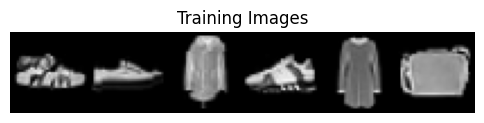

In [557]:
# Get a batch of real images
real_batch = next(iter(trainloader))
images, _ = real_batch

# Normalize the images to [0, 1] range for plotting
images = (images + 1) / 2

# Transpose the grid to match the expected shape for imshow
grid = torchvision.utils.make_grid(images[:6], padding=2, normalize=False)
grid = np.transpose(grid.cpu().numpy(), (1, 2, 0))

# Plot the grid of images
plt.figure(figsize=(6, 4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid)
plt.savefig(os.path.join(result_path, 'training_images.png'))
plt.show()


## Task 2: Training a GAN

In [558]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def print_parameters(net, name):
    num_params = 0
    for p in net.parameters():
        num_params += p.numel()
    
    print("{} has {:.3f}M parameters".format(name, num_params/1e6))

In [559]:
class Generator(nn.Module):
    """ Generator architecture """
    def __init__(self, z_channels=100,  nf=64, embed_dim=32, num_classes=10, out_channels=1, class_cond=True):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        self.latent_dim = z_channels
        self.class_cond = class_cond
        self.nf = nf

        if self.class_cond:
            self.embedding = nn.Embedding(num_classes, embed_dim) # class embeddings
        else:
            embed_dim = 0


        # fully connected input layer
        self.fc = nn.Linear(z_channels + embed_dim, 4*4*nf*8) # out: 132 x 8192
        self.bn = nn.BatchNorm2d(4*4*nf*8)

        # Convolutional layers
        # resource: https://distill.pub/2016/deconv-checkerboard/
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(nf*8, nf*4, kernel_size=3, stride=1, padding=1) # 512 x 256
        self.bn1 = nn.BatchNorm2d(nf*4)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2 = nn.Conv2d(nf*4, nf*2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(nf*2)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(nf*2, nf, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(nf)
        self.conv4 = nn.Conv2d(nf, out_channels, kernel_size=3, stride=1, padding=1)

        # activation functions
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, z, c=None):
        if self.class_cond and c is not None:
            c = self.embedding(c)
            z = torch.cat([z, c], dim=1)
        # Embed the input
        x = self.fc(z)
        x = self.relu(self.bn(x.view(x.size(0), -1, 1, 1)))  # Reshape to 4D

        # Reshape the input
        x = x.view(x.size(0), -1, 4, 4)  # Reshape to (batch_size, channels, 4, 4)

        # Apply the convolutional layers
        x = self.upsample1(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.upsample2(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.upsample3(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)

        # Apply a tanh activation for range [-1, 1]
        x = self.tanh(x)
        return x


    def set_grad(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad = requires_grad


class Discriminator(nn.Module):
    """ Discriminator architecture """
    def __init__(self, nf=64, embed_dim=32, out_channel=1, hidden_dim=100, dropout=0.0, num_classes=10, in_channel=1, class_cond=True):
        super(Discriminator, self).__init__()
        self.nf = nf
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        self.class_cond = class_cond

        if self.class_cond:
            self.embedding = nn.Embedding(num_classes, embed_dim)
        else:
            embed_dim = 0

        # convolutional layers
        self.conv1 = spectral_norm(nn.Conv2d(in_channel, nf, kernel_size=3, stride=1, padding=1, bias=True))
        self.conv2 = spectral_norm(nn.Conv2d(nf, nf*2, kernel_size=4, stride=2, padding=1,  bias=True))
        self.conv3 = spectral_norm(nn.Conv2d(nf*2, nf*4, kernel_size=4, stride=2, padding=1,  bias=True))
        self.conv4 = spectral_norm(nn.Conv2d(nf*4, nf*8, kernel_size=4, stride=2, padding=1,  bias=True))

        # Embedding layer
        self.embed = nn.Linear(4*4*nf*8 + embed_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Final output layer
        self.fc = spectral_norm(nn.Linear(hidden_dim, out_channel, bias=True))

        # activation functions
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, c=None):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.leaky_relu(self.conv4(x))

        # Flatten the output
        x = rearrange(x, "b c h w -> b (c h w)")

        if self.class_cond and c is not None:
            c = self.embedding(c)
            x = torch.cat([x, c], dim=1)

        x = self.leaky_relu(self.embed(x))
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def set_grad(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad = requires_grad


class DCGAN(nn.Module):
    def __init__(self,
                 latent_dim=100,
                 img_size=32,
                 g_lr=1e-3,
                 d_lr=1e-4,
                 betas=(0.5, 0.999),
                 momentum=1.e-5,
                 nf=64,
                 embed_dim=16,
                 num_classes=10,
                 dropout=0.0,
                 class_cond=True,
                 device=None):
        super(DCGAN, self).__init__()

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.d_lr = d_lr
        self.g_lr = g_lr
        self.betas = betas
        self.momentum = momentum
        self.embed_dim = embed_dim
        self.nf = nf
        self.num_classes = num_classes
        self.dropout = dropout
        self.class_cond = class_cond

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.device = device

        self.input_shape = (1, self.img_size, self.img_size)
        self.z_fixed_noise = torch.randn((1, self.latent_dim))
        self.c_fixed = torch.LongTensor([0]).to(device)

        self.real_label = 1
        self.fake_label = 0

        # Initialize Generator (G) and Discriminator (D) network
        self.generator = Generator(z_channels=self.latent_dim, 
                                   nf=self.nf,
                                   embed_dim=self.embed_dim,
                                   num_classes=self.num_classes, 
                                   class_cond=self.class_cond)
        
        self.discriminator = Discriminator(nf=self.nf, 
                                           embed_dim=self.embed_dim, 
                                           dropout=self.dropout,
                                           num_classes=self.num_classes, 
                                           class_cond=self.class_cond)

        # Print number of parameters
        self.print_parameters(self.generator, "Generator")
        self.print_parameters(self.discriminator, "Discriminator")

        # Initialize weights
        self.generator.apply(self.weights_init)
        # self.discriminator.apply(self.weights_init) - use spectral normalization instead

        # Initialize loss criterion and optimizer
        self.criterion = nn.BCEWithLogitsLoss()
        self.optim_G = optim.Adam(self.generator.parameters(), lr=self.g_lr, betas=self.betas, weight_decay=self.momentum)
        self.optim_D = optim.Adam(self.discriminator.parameters(), lr=self.d_lr, betas=self.betas, weight_decay=self.momentum)


    def sample_random_z(self, img_size, latent_dim=100, device=None):
        """ Random noise vector z."""
        if device is None:
            device = self.device
        return torch.randn((img_size, latent_dim)).to(device)

    def sample_fixed_z(self, device=None):
        """Fixed noise vector z."""
        if device is None:
            device = self.device
        return self.z_fixed_noise.to(device), self.c_fixed.to(device)

    def sample_G(self, latent_dim=100, device=None):
        """ Generate fake images from random noise z."""
        if device is None:
            device = self.device
        z = torch.randn((latent_dim), (latent_dim)).to(device)
        random_y = torch.LongTensor(np.expand_dims(np.linspace(0, 9, 10), 1).repeat(10,1)).to(device).flatten()
        fake_imgs = self.generator(z, random_y)
        return fake_imgs

    def train_step(self, real_images, real_labels, device=None):

        if device is None:
            device = self.device

        # if not on device move to device
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)

        # ============================================================= #
        # ================== Train the discriminator ================== #
        # ============================================================= #
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        self.discriminator.set_grad(requires_grad=True)
        self.optim_D.zero_grad()

        # Real images
        real_pred = self.discriminator(real_images, real_labels)
        d_real_loss = self.criterion(real_pred, torch.ones_like(real_pred))

        # Fake images
        z_d = self.sample_random_z(img_size=real_images.size(0), latent_dim=self.latent_dim, device=self.device)
        with torch.no_grad():
            fake_images_d = self.generator(z_d, real_labels)

        fake_pred1 = self.discriminator(fake_images_d, real_labels)
        d_fake_loss = self.criterion(fake_pred1, torch.zeros_like(fake_pred1))

        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        self.optim_D.step()

        self.discriminator.set_grad(requires_grad=False) # freeze discriminator
        
        # ============================================================= #
        # ===================== Train the generator =================== #
        # ============================================================= #

        # (2) Update G network: maximize log(D(G(z)))
        self.optim_G.zero_grad()

        # Fake images
        z_g = self.sample_random_z(img_size=real_images.size(0), latent_dim=self.latent_dim, device=self.device)
        fake_images_g = self.generator(z_g, real_labels)
        fake_pred2 = self.discriminator(fake_images_g, real_labels)
        g_loss = self.criterion(fake_pred2, torch.ones_like(fake_pred2)) # discriminator should predict 1 (real)

        g_loss.backward()
        self.optim_G.step()

        # compute accuracy
        real_acc = torch.round(torch.sigmoid(real_pred)).squeeze()
        fake_acc = torch.round(torch.sigmoid(fake_pred1)).squeeze()

        return d_real_loss, d_fake_loss, g_loss, real_acc, fake_acc

    # custom weights initialization called on ``netG`` and ``netD``
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def print_parameters(self, net, name):
        num_params = 0
        for p in net.parameters():
            num_params += p.numel()

        print("{} has {:.3f}M parameters".format(name, num_params/1e6))
    
    def save(self, path):
        # Save the model
        torch.save(self.generator.state_dict(), os.path.join(path, 'generator.pth'))
        torch.save(self.discriminator.state_dict(), os.path.join(path, 'discriminator.pth'))

In [560]:
class Classifier(nn.Module):
    def __init__(self, nf=64, latent_dim=100, num_classes=10) -> None:
        super(Classifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, nf, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(nf)
        self.conv2 = nn.Conv2d(nf, nf*2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(nf*2)
        self.conv3 = nn.Conv2d(nf*2, nf*4, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(nf*4)
        self.conv4 = nn.Conv2d(nf*4, nf*8, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(nf*8)
        # Dense layers
        self.fc = nn.Linear(4*nf, latent_dim)
        self.fc2 = nn.Linear(latent_dim, num_classes)

    def get_features(self, x):
        # Feature extraction
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True)
        # Global average pooling
        x = torch.mean(x, dim=(2, 3))
        # Classification layer
        x = F.leaky_relu(self.fc(x), 0.2, inplace=True)
        return x

    def forward(self, x):
        # Pass through the convolutional layers
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True)
        x = x.view(-1, 4*self.nf)
        x = F.leaky_relu(self.fc(x), 0.2, inplace=True)
        # Features
        x = self.fc2(x)
        return x

In [561]:
# Initialize DCGAN
dcgan = DCGAN(    latent_dim=config_dict['latent_dim'],
                  embed_dim=config_dict['embed_dim'],
                  img_size=config_dict['img_size'],
                  d_lr=config_dict['d_lr'],
                  g_lr=config_dict['g_lr'],
                  betas=config_dict['betas']
                  )

dcgan.to(device)

Generator has 2.525M parameters
Discriminator has 3.575M parameters


DCGAN(
  (generator): Generator(
    (embedding): Embedding(10, 16)
    (fc): Linear(in_features=116, out_features=8192, bias=True)
    (bn): BatchNorm2d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (upsample1): Upsample(scale_factor=2.0, mode='nearest')
    (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (upsample2): Upsample(scale_factor=2.0, mode='nearest')
    (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (upsample3): Upsample(scale_factor=2.0, mode='nearest')
    (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [562]:
num_epochs = config_dict['num_epochs']

losses_avg_train = {"GLoss": [], "Dreal": [], "Dfake": []}
acc_real = []
acc_fake = []

col_fix_images = []

# Train DCGAN
for epoch in range(1, num_epochs + 1):

    dcgan.train()
    dcgan.generator.train()
    dcgan.discriminator.train()

    cur_losses = {"GLoss": [], "Dreal": [], "Dfake": []}

    num_total = 0
    num_right_real = 0
    num_right_fake = 0

    for i, data in enumerate(trainloader):
        images, targets = data
        images = images.to(device)
        targets = targets.to(device)

        # Train the DCGAN
        d_real_loss, d_fake_loss, g_loss, real_acc, fake_acc = dcgan.train_step(images, targets)

        cur_losses["GLoss"].append(g_loss.item())
        cur_losses["Dreal"].append(d_real_loss.item())
        cur_losses["Dfake"].append(d_fake_loss.item())

        num_total += images.size(0)
        num_right_real += torch.sum(torch.eq(real_acc, torch.ones_like(targets))).cpu().numpy()
        num_right_fake += torch.sum(torch.eq(fake_acc, torch.zeros_like(targets))).cpu().numpy()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, num_epochs, i+1, len(trainloader), (d_real_loss.item() + d_fake_loss.item()), g_loss.item()))

    # Store accuracies
    for k,v in cur_losses.items():
        losses_avg_train[k].append(np.mean(v))
    acc_real.append(num_right_real/num_total*100.0)
    acc_fake.append(num_right_fake/num_total*100.0)

    # Set the model to evaluation mode
    dcgan.eval()
    dcgan.generator.eval()
    dcgan.discriminator.eval()

    # Generate 10 x 5 images for each epoch
    with torch.no_grad():
        print(f"Generating Images for Epoch: {epoch+1}")
        fake_imgs = dcgan.sample_G(latent_dim=100, device=device)
        fake_imgs = F.interpolate(fake_imgs, scale_factor=2.0, mode="nearest")
        fake_imgs = (fake_imgs.cpu()+1.0)*0.5
        grid = torchvision.utils.make_grid(fake_imgs, nrow=10)
        grid = grid.permute(1,2,0).numpy()
        col_fix_images.append(grid)
        os.makedirs("samples", exist_ok=True)
        # plot images
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title(f"Fake Images Epoch {epoch+1}")
        plt.imshow(grid)
        plt.show()
        plt.imsave(f"{result_path}/fake_images_epoch_{epoch+1}.png", grid)

    #plot losses
    plt.figure(dpi=300)
    plt.title(f"GAN Losses Epoch {epoch+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    for k, v in losses_avg_train.items():
            plt.plot(np.arange(1, epoch+1), v, label=k)

    plt.legend()
    plt.show()
    plt.savefig(f"{result_path}/losses.png")

    # plot accuracies
    plt.figure(dpi=300)
    plt.title("Classification Accuracies Discriminator")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy [%]")
    plt.plot(np.arange(1, epoch+1), acc_real, label="Real")
    plt.plot(np.arange(1, epoch+1), acc_fake, label="Fake")
    plt.legend()
    plt.show()
    plt.savefig(f"{result_path}/accuracy.png")

    #generate image for fixed noise vektor
    if epoch%5==0:
        with torch.no_grad():
            zfix, cfix = dcgan.sample_fixed_z()
            fix_images = dcgan.generator(zfix, cfix)
            col_fix_images.append((F.interpolate(fix_images, scale_factor=2.0, mode="nearest").cpu()+1.0)*0.5)


# Save the model under model_path
dcgan.save(model_path + '/dcgan.pth')


KeyboardInterrupt: 

## Train Classifier on Fashion-MNIST Dataset

In [ ]:
# Initialize the cnn model
cnn = Classifier(nf=config_dict['img_size']).to(device)
print_parameters(cnn, "Classifier")

# Hyperparameters
lr = 1e-4
betas = (0.5, 0.999)

# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr, betas=betas)

losses_avg_train = []
losses_avg_test = []
acc_train = []
acc_test = []

num_epochs = 50
epoch_decay = 10

for epoch in range(num_epochs):
    
    # Time measurements
    start = time.time()

    # --- Train the model --- #
    cnn.train()
    curr_loss = []
    total = 0
    correct = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients (avoid accumulation)
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()

        # Store the loss
        curr_loss.append(loss.item())

        # Calculate the accuracy
        total += labels.size(0)
        correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Store the training accuracy
    acc_train.append(correct/total*100.0)
    losses_avg_train.append(np.mean(curr_loss))

    print(f"Epoch {epoch+1}, Loss: {np.sum(curr_loss)/len(trainloader)}")

    # --- Test the model --- #
    cnn.eval()
    with torch.no_grad():
        curr_loss = []
        total = 0
        correct = 0
        for i, data in enumerate(testloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)

            # Store the loss
            curr_loss.append(loss.item())

            # Calculate the accuracy
            total += labels.size(0)
            correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Store the test accuracy
        acc_test.append(correct/total*100.0)
        losses_avg_test.append(np.mean(curr_loss))
    
    print(f"Test Loss: {np.mean(curr_loss)}")


    # Plot the training and test losses
    plt.figure(dpi=300)
    plt.title("Classification Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(np.arange(1, num_epochs+1), losses_avg_train, label="Train")
    plt.plot(np.arange(1, num_epochs+1), losses_avg_test, label="Test")
    plt.legend()
    plt.show()

    # Plot the training and test accuracies
    plt.figure(dpi=300)
    plt.title("Classification Accuracies")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy [%]")
    plt.plot(np.arange(1, num_epochs+1), acc_train, label="Train")
    plt.plot(np.arange(1, num_epochs+1), acc_test, label="Test")
    plt.legend()
    plt.show()

    # Save the model
    if acc_test[-1] > 0.9:
        best_acc = acc_test[-1]
        torch.save(cnn.state_dict(), model_path + '/cnn.pth')
    
    # Use the learning rate scheduler
    nlrg = lr * (1.0 - max(0, epoch - epoch_decay) / float(num_epochs - epoch_decay+1)) # linearly decay learning rate
    if epoch > epoch_decay:
        for param_group in optimizer.param_groups:
            param_group['lr'] = nlrg

    
    print("End of epoch {}. (Time taken: {:.3f}s)".format(epoch, time.time() - start))

### Plot the evaluation of Single Noise Vector

In [ ]:
#create a plot for the evaluation of a single noise vector
grid = torchvision.utils.make_grid(torch.cat(col_fix_images, dim=0), nrow=1)
grid = grid.permute(1,2,0).numpy()
plt.imsave("gan_evolve.png", grid)

plt.figure(dpi=100)
plt.imshow(grid)

#sample per class 5 images for visualization
samples = []
with torch.no_grad():
    for i in range(10):
        z = torch.randn((5,100)).to(device)
        target = torch.ones(5).long().to(device)*i
        
        imgs = dcgan.generator(z, target)
        imgs = F.interpolate(imgs, scale_factor=2.0, mode="nearest")
        samples.append((imgs.cpu()+1.0)*0.5)
samples = torch.cat(samples, dim=0)
grid = torchvision.utils.make_grid(samples, nrow=5)
grid = grid.permute(1,2,0).numpy()
plt.imsave("gan_samples.png", grid)

plt.figure(dpi=200)
plt.imshow(grid)

### Extract features from the CNN Classifier

In [ ]:
# Load the model
cnn.load_state_dict(torch.load(model_path + '/cnn.pth'))
cnn.to(device)

In [ ]:
# Randomly select 5 classes from the Fashion MNIST dataset
classes = np.random.choice(10, 5, replace=False)
print("Selected classes: ", classes)

n = 500
total_samples = 5*n
index = 0

features_train_set = [] # real trainingset features
features_test_set = [] # real testset features
features_gan_set = [] # generated features

# Track the number of examples per class
seen_examples_per_class = np.zeros(n)

# Collect features of the real training set
while np.sum(seen_examples_per_class) < total_samples:
    x, y = trainset[index]
    if y in classes:
        seen_examples_per_class[y] += 1
        x = x.unsqueeze(0).to(device)
        features_train_set.append(cnn.get_features(x).cpu().numpy())
    index += 1
features_train_set = np.concatenate(features_train_set, axis=0)

# Collect features of the real test set
index = 0
seen_examples_per_class = np.zeros(n)

while np.sum(seen_examples_per_class) < total_samples:
    x, y = testset[index]
    if y in classes:
        seen_examples_per_class[y] += 1
        x = x.unsqueeze(0).to(device)
        features_test_set.append(cnn.get_features(x).cpu().numpy())
    index += 1
features_test_set = np.concatenate(features_test_set, axis=0)

# Collect features of the generated images
for i in range(5):
    for c in 10:
        z = torch.randn((50, 100)).to(device)
        target = torch.ones(50).long().to(device)*i

        with torch.no_grad():
            imgs = dcgan.generator(z, target)
            features = cnn.get_features(imgs)
            features_gan_set.append(features.cpu().numpy())

features_gan_set = np.concatenate(features_gan_set, axis=0)

## TSNE-Projection of Train/Test/GAN Features

In [ ]:
# Perform t-SNE on the features
tsne = TSNE(n_components=2, random_state=42)
features = np.concatenate([features_train_set, features_test_set, features_gan_set], axis=0)
features_tsne = tsne.fit_transform(features)

# Plot the t-SNE features
plt.figure(dpi=300)
plt.title("t-SNE Projection of Features")
plt.scatter(features_tsne[:total_samples, 0], features_tsne[:total_samples, 1], c="blue", label="Real Training")
plt.scatter(features_tsne[total_samples:2*total_samples, 0], features_tsne[total_samples:2*total_samples, 1], c="red", label="Real Test")
plt.scatter(features_tsne[2*total_samples:, 0], features_tsne[2*total_samples:, 1], c="green", label="Generated")
plt.legend()
plt.show()
plt.savefig("tsne_features.png")

## Get Classification Accuracy for GAN images based on Classifier

In [ ]:
# Classification accuracy
classes = 10
accuracies = np.zeros(classes)

for c in range(classes):
    correct = 0
    total = 0

    for j in range(classes):
        # Generate 50 samples of each class
        z = torch.randn((50, 100)).to(device)
        target = torch.ones(50).long().to(device) * c # define target class

        with torch.no_grad():
            imgs = dcgan.generator(z, target)
            outputs = cnn(imgs)
            # Calculate the accuracy
            predicted = torch.argmax(outputs, dim=1)
            correct += torch.sum(torch.eq(predicted, target)).cpu().numpy() # count correct predictions

    accuracies[c] = correct / 500 * 100.0

# Output accuracies per class
print('Accuracy per class', ', '.join(map(lambda x: "{:.2f}%".format(x), accuracies)))
print('Mean accuracy {:.2f}%'.format(np.mean(accuracies)))

# Accuracies per class
plt.figure(dpi=300)
plt.title("Classification Accuracy per Class")
plt.xlabel("Classes")
plt.ylabel("Accuracy [%]")
plt.bar(np.arange(10), accuracies)
plt.show()